In [1]:
### INSTALL TRANSFORMERS PACKAGE
!pip install transformers

     |████████████████████████████████| 4.2 MB 7.0 MB/s 
     |████████████████████████████████| 596 kB 52.0 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 6.6 MB 40.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
### IMPORT REQUIRED PACKAGES
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn import metrics
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import time
from tqdm import tqdm
import math
from keras import layers, Model
from keras import backend as K
import tensorflow as tf
from torch.utils.data import TensorDataset, random_split
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [33]:
# cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True) # Whether the model returns all hidden-states.

categorical_features = ['INTER1', 'INTER2', 'INTERACTION', 'ADMIN1', 'SOURCE', 'SOURCE_SCALE', 'FATALITIES']

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    model.to(device)

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [38]:
# Multi Column Label Encoder for encoding labels across multiple columns
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [39]:
# LOAD DATAFRAME
filename = '/content/task_3_event_prediction.tsv'
dataframe = pd.read_csv(filename, delimiter='\t')

# DATA PREPROCESSING

# taking only data for India
dataframe = dataframe[dataframe['COUNTRY'] == 'India']

# taking only EVENT_DATE, EVENT_TYPE, INTER1, INTER2, INTERACTION, ADMIN1, SOURCE, SOURCE_SCALE, NOTES, FATALITIES
dataframe = dataframe[['EVENT_DATE', 'EVENT_TYPE', 'INTER1', 'INTER2', 'INTERACTION', 'ADMIN1', 'SOURCE', 
                       'SOURCE_SCALE', 'NOTES', 'FATALITIES']]

# drop nan values
dataframe = dataframe.dropna()
dataframe = dataframe.reset_index(drop=True)

# convert date to pd.datetime
dataframe['EVENT_DATE'] = pd.to_datetime(dataframe['EVENT_DATE'])

# encode event type as Protests = 1, Others = 0
dataframe['EVENT_TYPE'] = np.where(dataframe['EVENT_TYPE'] == 'Protests', 1, 0)

# reducing Inter1 by 1 to make minimum as 0
dataframe['INTER1'] = dataframe['INTER1'] - 1

# updating values in Interaction
# MinMaxScaler to normalize numerical values to between 0 and 1
scaler = MinMaxScaler(feature_range=(0, dataframe['INTERACTION'].nunique()))
dataframe[['INTERACTION']] = scaler.fit_transform(dataframe[['INTERACTION']])

# label encode the admin1, source, source_scale columns
dataframe = MultiColumnLabelEncoder(columns = ['ADMIN1', 'SOURCE', 'SOURCE_SCALE']).fit_transform(dataframe)

# normalize Fatalities as well. But there are values missing in here. What to do?
# MinMaxScaler to normalize numerical values to between 0 and 1
scaler = MinMaxScaler(feature_range=(0,dataframe['FATALITIES'].nunique()))
dataframe[['FATALITIES']] = scaler.fit_transform(dataframe[['FATALITIES']])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [40]:
### DATAFRAME SHAPE: (77892 * 10)
dataframe.shape

(77892, 10)

In [41]:
def get_notes_embeddings(df_notes):
  '''
  using bert base uncased pretrained model, retrieve the embedding for the notes column
  '''
  sentence_embeddings = None
  for note in df_notes:
      # Tokenize our sentence with the BERT tokenizer.
      tokenized_text = tokenizer.tokenize(note)
      # Map the token strings to their vocabulary indeces.
      indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
      segments_ids = [1] * len(tokenized_text)

      # Convert inputs to PyTorch tensors
      tokens_tensor = torch.tensor([indexed_tokens]).to(device)
      segments_tensors = torch.tensor([segments_ids]).to(device)
      # Run the text through BERT, and collect all of the hidden states produced
      # from all 12 layers. 
      with torch.no_grad():
          outputs = model(tokens_tensor, segments_tensors)

          # Evaluating the model will return a different number of objects based on 
          # how it's  configured in the `from_pretrained` call earlier. In this case, 
          # becase we set `output_hidden_states = True`, the third item will be the 
          # hidden states from all layers. See the documentation for more details:
          # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
          hidden_states = outputs[2]

      # Concatenate the tensors for all layers. We use `stack` here to
      # create a new dimension in the tensor.
      token_embeddings = torch.stack(hidden_states, dim=0)

      token_embeddings.size()
      # `hidden_states` has shape [13 x 1 x 22 x 768]

      # `token_vecs` is a tensor with shape [22 x 768]
      token_vecs = hidden_states[-2][0]

      # Calculate the average of all 22 token vectors.
      sentence_embedding = torch.mean(token_vecs, dim=0)
      sentence_embedding = sentence_embedding.view(1, sentence_embedding.size(0))
      if sentence_embeddings is None:
        sentence_embeddings = sentence_embedding        
      else:
        sentence_embeddings = torch.cat((sentence_embeddings, sentence_embedding), dim=0)        
    
  return sentence_embeddings

In [42]:
def get_entity_embedding_model(df, categorical_columns):
  '''
  Model to fit an embedded vector of the categorical columns to the event type column.
  '''
  inputs = []
  outputs = []
  for c in categorical_columns:
    num_unique_vals = int(df[c].nunique())
    embed_dim = int(min(np.ceil(num_unique_vals / 2), 50))
    inp = layers.Input(shape=(1, ))
    out = layers.Embedding(num_unique_vals + 1, embed_dim, name=c)(inp)
    #apply dropout here
    out = layers.Reshape(target_shape=(embed_dim, ))(out)
    inputs.append(inp)
    outputs.append(out)
  x = layers.Concatenate()(outputs)
  x = layers.Dense(300, activation='relu')(x)
  x = layers.Dropout(0.3)(x)
  y = layers.Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inputs, outputs = y)

  return model

In [43]:
############### CATEGORICAL EMBEDDING MODEL TRAINING
entity_embed_model = get_entity_embedding_model(dataframe, categorical_features)
entity_embed_model.compile(loss='binary_crossentropy', optimizer='adam')
entity_embed_model.fit(x = [dataframe.loc[:, f] for f in categorical_features], y = dataframe['EVENT_TYPE'].values, batch_size=16)

4869/4869 [==============================] - 32s 6ms/step - loss: 0.0054


In [44]:
def get_embeddings(tgt_df, seq_len):
  '''
    Function to concatenate the categorical embedding and notes embedding
    tgt_df: target dataframe for which the we are finding the embedding
    seq_len: sequence length to zero pad the embedding
  '''
  ############### EMBEDDINGS FOR CATEGORICAL FEATURES
  intermediate_layer_model = Model(inputs = entity_embed_model.input,
                                       outputs = entity_embed_model.get_layer(index=-4).output)

  categorical_embeddings = intermediate_layer_model([K.constant(tgt_df.loc[:, f]) for f in categorical_features])
  categorical_embeddings = torch.tensor(categorical_embeddings.numpy())
  categorical_embeddings = categorical_embeddings.to(device)

  ############### GET BERT EMBEDDINGS FOR NOTES
  notes_embeddings = get_notes_embeddings(tgt_df['NOTES'])  

  ############### CONCAT CATEGORICAL EMBEDDING AND NOTES EMBEDDING
  embedded_tensor = torch.cat((categorical_embeddings, notes_embeddings), dim=1)

  ############### ZERO PADDING IF LENGTH LESS THAN SEQUENCE LENGTH
  original_length = embedded_tensor.shape[0]
  if(embedded_tensor.shape[0] < seq_len):
    rows_count_to_append = seq_len - embedded_tensor.shape[0]
    print(f'Notes embedding size: {notes_embeddings.size()}, Categorical embedding size: {categorical_embeddings.size()}, Rows to append: {rows_count_to_append}')
    cols = embedded_tensor.shape[1]
    new_rows_tensor = torch.zeros(rows_count_to_append, cols).to(device)
    embedded_tensor = torch.cat((embedded_tensor, new_rows_tensor), dim=0)
  else:
    print(f'Notes embedding size: {notes_embeddings.size()}, Categorical embedding size: {categorical_embeddings.size()}')

  return embedded_tensor, original_length

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


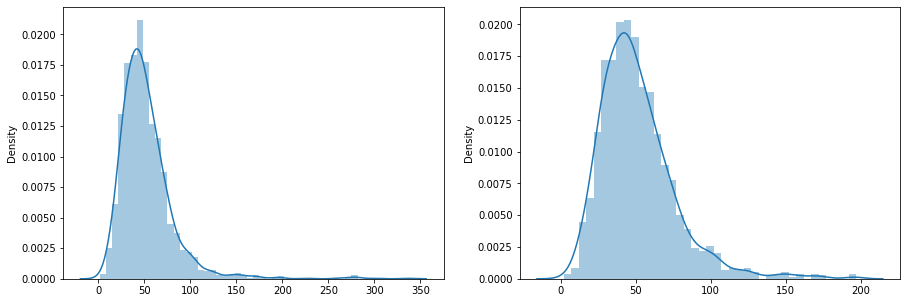

In [45]:
############### ROW COUNTS OF DATA GROUPED BY EVENT DATE TO INITIALISE A VALUE FOR SEQUENCE LENGTH
event_date_grouping_row_counts = []

for label, df in dataframe.groupby('EVENT_DATE'):
  event_date_grouping_row_counts.append(df.shape[0])

############### DENSITY DISTRIBUTION PLOT OF THE ROW COUNT
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(event_date_grouping_row_counts)
plt.subplot(1,2,2)
sns.distplot([i for i in event_date_grouping_row_counts if i <= 200])
plt.show()

In [ ]:
########### CALCULATE VALUES FOR EVENT_DATE, PROTEST_COUNTS, TARGET CLASS (index which is mapped to a target class dict), 
########### EMBEDDING TARGET (mapped to an embedding dict), AND EMBEDDINGS_DICT FOR EACH UNIQUE EVENT_DATE

#######################################################
#### DICTIONARY OF THE TARGET CLASSES
target_classes_dict = dict()
i = 0
while i<=150:
  target_classes_dict[int(i/10)] = f'[{i}, {i+10})'
  i = i+10

#######################################################

min_sequence_length = 10
max_sequence_length = 90

event_dates = []
protest_counts = []
target_classes = []
embedding_target = []
embeddings_dict = dict()
i = 0

for label, df in dataframe.groupby('EVENT_DATE'):
  if(df.shape[0] > max_sequence_length or df.shape[0] < min_sequence_length):
    continue
  event_dates.append(label.strftime('%m/%d/%Y'))
  protest_counts.append(df['EVENT_TYPE'].sum())
  target_classes.append(int(df['EVENT_TYPE'].sum()/10))
  embedding_target.append(i)
  embeddding, seq_len = get_embeddings(df, max_sequence_length)
  embeddings_dict[i] = (embeddding, seq_len)
  i = i+1

In [ ]:
###### EMBEDDING SHAPE SHOULD BE SAME FOR ALL THE EMBEDDINGS AS WE HAVE PADDED THEM WITH ZEROS (seq_len = 90)
for idx, i in enumerate(embedding_target):
  print(f'embedding shape for {idx} is {((embeddings_dict[i])[0]).shape}')

In [49]:
final_df = pd.DataFrame(list(zip(event_dates, protest_counts, embedding_target, target_classes)), 
                        columns =['EVENT_DATE', 'PROTEST_COUNTS', 'EMBEDDING_KEY', 'TARGET_CLASS_KEY'])

###### FINAL DATAFRAME, SHAPE: 1368 * 4
final_df

,EVENT_DATE,PROTEST_COUNTS,EMBEDDING_KEY,TARGET_CLASS_KEY
0,01/01/2018,19,0,1
1,01/02/2018,36,1,3
2,01/03/2018,44,2,4
3,01/04/2018,22,3,2
4,01/05/2018,30,4,3
...,...,...,...,...
1363,01/17/2022,18,1363,1
1364,01/18/2022,29,1364,2
1365,01/19/2022,27,1365,2
1366,01/20/2022,33,1366,3


In [ ]:
for idx, i in enumerate(protest_counts):
  print(f'Protests count for day {idx+1}: {i}, Class Interval: {target_classes_dict[target_classes[idx]]}, Target Class: {target_classes[idx]}')

In [291]:
#### splitting into input (embed key) and output data (target class key)
X_data, Y_data = final_df['EMBEDDING_KEY'], torch.tensor(final_df['TARGET_CLASS_KEY']).to(device)

In [292]:
### BATCH SIZE USED IN GRU1 AND GRU2
dataloader_batch_size = 16

def get_dataloader(x, x_len, y):
  '''
  Creates the dataloader using the input x, input length x_len and output y.
  '''
  data = TensorDataset(x, x_len, y)
  dataloader = DataLoader(data, batch_size=dataloader_batch_size)
  return dataloader

def load_data_for_dataloader(x, y):
  '''
  Load the data into X as seq_len * embedding size.
  Returns X, its unpadded length, and Y.
  '''
  x_embedded_tensors = None
  y_embedded_tensors = None
  x_len = []
  for idx, i in enumerate(x):
    embed_dict_tuple = embeddings_dict[i]
    embedding_t = (embed_dict_tuple[0])[None, :, :]
    y_train = y[idx].repeat(embedding_t.size(0))
    if x_embedded_tensors is None:
      x_embedded_tensors = embedding_t
    else:
      x_embedded_tensors = torch.cat((x_embedded_tensors, embedding_t), dim=0)
    x_len.append(embed_dict_tuple[1])
    if y_embedded_tensors is None:
      y_embedded_tensors = y_train
    else:
      y_embedded_tensors = torch.cat((y_embedded_tensors, y_train), dim=0)
  
  return x_embedded_tensors, torch.tensor(x_len), y_embedded_tensors

split_ratio = 0.80
### LOAD THE DATA IN REQD FORMAT TO CREATE THE DATALOADER
flatten_x_train, flatten_x_len, flatten_y_train = load_data_for_dataloader(X_data, Y_data)

#### TRAINING SET
X_training_set = flatten_x_train[:int(flatten_x_train.shape[0]*split_ratio)]
X_train_len = flatten_x_len[:int(flatten_x_train.shape[0]*split_ratio)]
Y_training_set = flatten_y_train[:int(flatten_x_train.shape[0]*split_ratio)]

#### VALIDATION SET
X_test_set = flatten_x_train[int(flatten_x_train.shape[0]*split_ratio):]
X_test_len = flatten_x_len[int(flatten_x_train.shape[0]*split_ratio):]
Y_test_set = flatten_y_train[int(flatten_x_train.shape[0]*split_ratio):]

#### TRAIN AND TEST DATALOADERS
train_dataloader = get_dataloader(X_training_set.to(device), X_train_len, Y_training_set)
test_dataloader = get_dataloader(X_test_set.to(device), X_test_len, Y_test_set)

In [293]:
for batch in train_dataloader:
  x, x_len, y = batch
  print(x.shape, x_len.shape, y.shape)
  break

torch.Size([16, 90, 885]) torch.Size([16]) torch.Size([16])


In [294]:
### GRU MODEL 1 WHICH GIVES THE VECTOR REPRESENTATION OF ONE SINGLE DAY.
class GRUClassifier1(nn.Module):
    def __init__(self, 
                 input_size_1, 
                 hidden_size_1, 
                 num_layers_1, 
                 dropout_1,
                 directions_1, 
                 bidirectional_1,
                 batch_size_1):
        super().__init__()
        ###############################################################
        self.input_size_1 = input_size_1
        self.dropout_1 = nn.Dropout(dropout_1)
        self.directions_1 = directions_1
        self.num_layers_1 = num_layers_1
        self.hidden_dim_1 = hidden_size_1
        self.gru_1 = nn.GRU(input_size=self.input_size_1,
                          hidden_size=self.hidden_dim_1,
                          num_layers=self.num_layers_1,
                          dropout=dropout_1,
                          bidirectional=bidirectional_1)        
    
    def forward(self, x, x_lens):        
        ###############################################################
        x_1 = x
        # x_1: [batch, seq len, emb dim] => [5 * 80 * 810]

        # GRU 1
        x_1 = x_1.permute(1, 0, 2) # [seq len, batch, emb dim] ==> [80 * 5 * 810]

        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(x_1, x_lens.to('cpu'), batch_first=False, enforce_sorted=False)        
        
        output_1, h_n_1 = self.gru_1(packed)
        h_n_1 = self.dropout_1(h_n_1[-1, :, :])
        # output_1 => [seq len * batch * hidden dim] ... [80 * 5 * 256]
        # h_n_1 => [num layers * batch * hidden dim] ... [2 * 5 * 256]
        # print(f'output dim 1: {output_1.shape}, h_n dim 1: {h_n_1.shape}')

        return h_n_1

In [295]:
### GRU MODEL 2 WHICH TAKES THE VECTOR REPRESENTATION FOR EVERY DAY IN THE BATCH AND PREDICTS OUTPUT FOR Nth DAY.
class GRUClassifier2(nn.Module):
  def __init__(self,
                input_size_2,
                hidden_size_2,
                num_layers_2, 
                dropout_2,
                directions_2, 
                bidirectional_2,
                batch_size_2,
                classes=2):
    super().__init__()
    ###############################################################
    self.input_size_2 = input_size_2
    self.dropout_2 = nn.Dropout(dropout_2)
    self.directions_2 = directions_2
    self.num_layers_2 = num_layers_2
    self.hidden_dim_2 = hidden_size_2
    self.gru_2 = nn.GRU(input_size=self.input_size_2,
                      hidden_size=self.hidden_dim_2,
                      num_layers=self.num_layers_2,
                      dropout=dropout_2,
                      bidirectional=bidirectional_2)
    ###############################################################
    self.fc = nn.Linear(self.hidden_dim_2, classes)

  def forward(self, x):
    ###############################################################
    #x_2 = (h_n_1[-1, :, :])[None, :, :] # x_2: [batch, seq len, emb dim] => [1 * 5 * 256]
    x_2 = x
    # GRU 2

    # print(f'x_2 initial dim: {x_2.shape}')
    x_2 = x_2.permute(1, 0, 2) # [seq len, batch, emb dim] => [5 * 1 * 256]

    output_2, h_n_2 = self.gru_2(x_2)
    h_n_2 = self.dropout_2(h_n_2[-1, :, :])
    # output_2 => [seq len * batch * hidden dim] ... [5 * 1 * 128]
    # h_n_2 => [num layers * batch * hidden dim] ... [2 * 1 * 128]
    # print(f'output dim 2: {output_2.shape}, h_n dim 2: {h_n_2.shape}')

    ###############################################################
    fc_input = h_n_2 # [1 * 128]
    # print(f'fc input dim: {fc_input.shape}')
    out = self.fc(fc_input) # [1 * 6]
    # print(f'out shape: {out}')

    return out

In [296]:
### CLASSIFIER MODULE COMBINING GRU 1 AND GRU 2
class GRUClassifier(nn.Module):
  def __init__(self, 
               gru_model_1, 
               gru_model_2,
               n_past,
               n_future):
      super().__init__()
      ###############################################################
      self.gru_model_1 = gru_model_1
      self.gru_model_2 = gru_model_2
      self.n_past = n_past
      self.n_future = n_future
      self.epoch_no = -1
      self.unprocessed_x_train = None

  def to_sequence(self, gru_1_out):
    X_train = None
    if(self.unprocessed_x_train is not None):
      # dummy_tensor = (torch.zeros(self.unprocessed_x_train.size())).to(device)
      dummy_tensor = (self.unprocessed_x_train.clone().detach()).to(device)
      gru_1_out = torch.cat((dummy_tensor, gru_1_out), dim=0)
      self.unprocessed_x_train = None
    
    for i in range(self.n_past, gru_1_out.size(0) - self.n_future + 1):
      x_train_past = (gru_1_out[(i - self.n_past) : i, :])[None, :, :]
      if X_train is None:
        X_train = x_train_past
      else:
        X_train = torch.cat((X_train, x_train_past), dim=0)

    row_size = gru_1_out.size(0)
    self.unprocessed_x_train = gru_1_out[(row_size - self.n_past - self.n_future + 1):, :]

    # X_train = torch.tensor(X_train)
    # print(f'X_train size: {X_train.size()}')
    return X_train
  
  def forward(self, x, x_lens, epoch_no):
    if self.epoch_no != epoch_no:
      self.unprocessed_x_train = None
      self.epoch_no = epoch_no

    gru_1_out = self.gru_model_1(x, x_lens) # batch size * hidden dim ===> 5 * 256
    #print(f'############### GRU MODEL 1 OUTPUT SHAPE: {gru_1_out.shape} ###############')

    gru_2_in = self.to_sequence(gru_1_out) # for n_past = 2, n_future = 1; gru_2_in ===> 3 * 2 * 256 ===> seq len = 2, batch size = 3    
    #print(f'############### GRU MODEL 2 INPUT SHAPE: {gru_2_in.shape} ###############')

    gru_2_out = self.gru_model_2(gru_2_in) # 3 * 6
    #print(f'############### GRU MODEL 2 OUTPUT SHAPE: {gru_2_out.shape} ###############')

    return gru_2_out

In [305]:
# number of past days we want to use to predict into the future
global_n_past=3
# number of days we want to predict into the future  
# must be less than batch size
# LEAD TIME
global_n_future=3

##########################################
input_size_1 = X_training_set.shape[2]
hidden_size_1 = 256
num_layers_1 = 2
dropout_1 = 0.3
directions_1 = 1
bidirectional_1 = False
batch_size_1 = dataloader_batch_size
##########################################
input_size_2 = hidden_size_1
hidden_size_2 = 128
num_layers_2 = 2
dropout_2 = 0.4
directions_2 = 1
bidirectional_2 = False
batch_size_2 = dataloader_batch_size
##########################################
classes = max(final_df['TARGET_CLASS_KEY'])+1
##########################################
gru_model_1 = GRUClassifier1(input_size_1, hidden_size_1, num_layers_1, dropout_1, directions_1, bidirectional_1, batch_size_1)
##########################################
gru_model_2 = GRUClassifier2(input_size_2, hidden_size_2, num_layers_2, dropout_2, directions_2, bidirectional_2, batch_size_2,
                          classes)
##########################################
gru_model = GRUClassifier(gru_model_1, gru_model_2, global_n_past, global_n_future)
if torch.cuda.is_available():
   gru_model.cuda()

In [306]:
gru_model

GRUClassifier(
  (gru_model_1): GRUClassifier1(
    (dropout_1): Dropout(p=0.3, inplace=False)
    (gru_1): GRU(885, 256, num_layers=2, dropout=0.3)
  )
  (gru_model_2): GRUClassifier2(
    (dropout_2): Dropout(p=0.4, inplace=False)
    (gru_2): GRU(256, 128, num_layers=2, dropout=0.4)
    (fc): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [307]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The GRU model has {count_parameters(gru_model):,} trainable parameters')

The GRU model has 1,521,033 trainable parameters


In [308]:
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.AdamW(gru_model.parameters(), lr = 2e-4)

In [309]:
# Training function: Performs forward propagation, backpropagation & optimization.
# We also implement gradient clipping, which prevents the gradients from exploding
def to_sequence(y_train, unprocessed_y_train):
  Ytrain = None

  if(unprocessed_y_train is not None):
    y_train = torch.cat((unprocessed_y_train, y_train), dim=0)

  for i in range(global_n_past, y_train.size(0) - global_n_future + 1):
    y_train_past = y_train[i + global_n_future - 1: i + global_n_future]
    if Ytrain is None:
      Ytrain = y_train_past 
    else:
      Ytrain = torch.cat((Ytrain, y_train_past), dim=0)
  
  row_size = y_train.size(0)
  unprocessed_y_train = y_train[(row_size - global_n_past - global_n_future + 1):]

  return Ytrain, unprocessed_y_train

def train(gru_model, dataloader, optimizer, criterion, epoch_no, clip=1.0):

    gru_model.train()

    ep_t_loss = 0
    batch_num  = 0
    pred, tgt = [], []
    unprocessed_y_train = None
    
    for ix, batch in enumerate(dataloader):
        x, x_lens, y = batch        
        x = x.to(device)
        x_lens = x_lens.to(device)
        y = y.to(device)
        
        #print(f'\n############### ITERATION {ix} ###############')

        optimizer.zero_grad()
        output_pred = gru_model(x, x_lens, epoch_no)
        #print(f'############### OUTPUT PRED SHAPE: {output_pred.shape} ###############')
        y_train, unprocessed_y_train = to_sequence(y, unprocessed_y_train)
        #print(f'############### Y_TRAIN MODIFIED SHAPE: {y_train.shape} ###############')
        # y_train = y
        #print(f'Iteration {ix}; Y_Train size: {y_train.size()}')
        loss = criterion(output_pred, y_train)
        loss.backward()

        #gradient clipping
        torch.nn.utils.clip_grad_norm_(gru_model.parameters(), clip)
        optimizer.step()

        #print(f'############### END OF ITERATION {ix} ###############')
        ep_t_loss += loss.item()
        batch_num += 1
        pred.extend(torch.argmax(output_pred, -1).tolist())
        tgt.extend(y_train.tolist())

    return ep_t_loss/batch_num, metrics.f1_score(tgt, pred, average='macro')

In [310]:
# Evaluation function: Calculates loss on the validation data.
from sklearn import metrics

def evaluate(gru_model, dataloader, criterion, optimizer, epoch_no):

    model.eval()
    ep_t_loss = 0
    batch_num  = 0
    pred, tgt = [], []
    unprocessed_y_test = None
    for ix, batch in enumerate(dataloader):
        x, x_lens, y = batch
        x = x.to(device)
        x_lens = x_lens.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()

        with torch.no_grad():
            output = gru_model(x, x_lens, epoch_no)
            y_test, unprocessed_y_test = to_sequence(y, unprocessed_y_test)
            loss = criterion(output, y_test)

            ep_t_loss += loss.item()
            batch_num += 1
            pred.extend(torch.argmax(output, -1).tolist())
            tgt.extend(y_test.tolist())
        
    return ep_t_loss/batch_num, metrics.f1_score(tgt, pred, average='macro'), pred, tgt

In [311]:
best_valid_loss = float('inf')
tot_t_loss, tot_v_loss =[],[]
tr_f1_score, val_f1_score = [], []
N_EPOCHS = 100

for epoch in tqdm(range(N_EPOCHS)): 

    tr_l, tr_f1= train(gru_model, train_dataloader, optim, criterion, epoch/2)
    tot_t_loss.append(tr_l)
    tr_f1_score.append(tr_f1)

    val_l, val_f1, pred, tgt = evaluate(gru_model, test_dataloader, criterion, optim, (epoch/2)+1)
    tot_v_loss.append(val_l)
    val_f1_score.append(val_f1)
    
    # if val_l < best_valid_loss:
    #     best_valid_loss = val_l
    #     best_pred, best_tgt = pred, tgt
    #     torch.save(model.state_dict(), 'model_least_loss.pt')
    #     print("\nBest Model Saved !!")
    # elif epoch % 3 == 0:
    #     torch.save(model.state_dict(), 'model_checkpoint_'+str(epoch)+'.pt')
    #     print("\Checkpoint Model Saved !!")

    print("\n")
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Total Loss: {tr_l:.3f} | Train F1: {tr_f1:.3f}')
    print(f'\tVal. Total Loss: {val_l:.3f} | Valid F1: {val_f1:.3f}')
    print("_________________________________________________________________")

  1%|          | 1/100 [00:00<01:32,  1.07it/s]



Epoch: 01
	Train Total Loss: 2.037 | Train F1: 0.078
	Val. Total Loss: 1.980 | Valid F1: 0.082
_________________________________________________________________


  2%|▏         | 2/100 [00:01<01:30,  1.08it/s]



Epoch: 02
	Train Total Loss: 1.950 | Train F1: 0.084
	Val. Total Loss: 1.961 | Valid F1: 0.084
_________________________________________________________________


  3%|▎         | 3/100 [00:02<01:28,  1.10it/s]



Epoch: 03
	Train Total Loss: 1.934 | Train F1: 0.082
	Val. Total Loss: 1.958 | Valid F1: 0.088
_________________________________________________________________


  4%|▍         | 4/100 [00:03<01:26,  1.10it/s]



Epoch: 04
	Train Total Loss: 1.943 | Train F1: 0.077
	Val. Total Loss: 1.948 | Valid F1: 0.084
_________________________________________________________________


  5%|▌         | 5/100 [00:04<01:25,  1.11it/s]



Epoch: 05
	Train Total Loss: 1.935 | Train F1: 0.078
	Val. Total Loss: 1.938 | Valid F1: 0.084
_________________________________________________________________


  6%|▌         | 6/100 [00:05<01:24,  1.12it/s]



Epoch: 06
	Train Total Loss: 1.939 | Train F1: 0.072
	Val. Total Loss: 1.927 | Valid F1: 0.101
_________________________________________________________________


  7%|▋         | 7/100 [00:06<01:23,  1.11it/s]



Epoch: 07
	Train Total Loss: 1.920 | Train F1: 0.077
	Val. Total Loss: 1.942 | Valid F1: 0.089
_________________________________________________________________


  8%|▊         | 8/100 [00:07<01:22,  1.11it/s]



Epoch: 08
	Train Total Loss: 1.934 | Train F1: 0.078
	Val. Total Loss: 1.938 | Valid F1: 0.101
_________________________________________________________________


  9%|▉         | 9/100 [00:08<01:21,  1.11it/s]



Epoch: 09
	Train Total Loss: 1.925 | Train F1: 0.078
	Val. Total Loss: 1.960 | Valid F1: 0.081
_________________________________________________________________


 10%|█         | 10/100 [00:09<01:21,  1.11it/s]



Epoch: 10
	Train Total Loss: 1.928 | Train F1: 0.071
	Val. Total Loss: 1.948 | Valid F1: 0.067
_________________________________________________________________


 11%|█         | 11/100 [00:09<01:20,  1.10it/s]



Epoch: 11
	Train Total Loss: 1.917 | Train F1: 0.082
	Val. Total Loss: 1.946 | Valid F1: 0.087
_________________________________________________________________


 12%|█▏        | 12/100 [00:10<01:19,  1.11it/s]



Epoch: 12
	Train Total Loss: 1.918 | Train F1: 0.070
	Val. Total Loss: 1.950 | Valid F1: 0.075
_________________________________________________________________


 13%|█▎        | 13/100 [00:11<01:17,  1.12it/s]



Epoch: 13
	Train Total Loss: 1.925 | Train F1: 0.079
	Val. Total Loss: 1.940 | Valid F1: 0.092
_________________________________________________________________


 14%|█▍        | 14/100 [00:12<01:16,  1.12it/s]



Epoch: 14
	Train Total Loss: 1.921 | Train F1: 0.077
	Val. Total Loss: 1.959 | Valid F1: 0.067
_________________________________________________________________


 15%|█▌        | 15/100 [00:13<01:16,  1.11it/s]



Epoch: 15
	Train Total Loss: 1.913 | Train F1: 0.076
	Val. Total Loss: 1.939 | Valid F1: 0.062
_________________________________________________________________


 16%|█▌        | 16/100 [00:14<01:15,  1.11it/s]



Epoch: 16
	Train Total Loss: 1.923 | Train F1: 0.066
	Val. Total Loss: 1.932 | Valid F1: 0.078
_________________________________________________________________


 17%|█▋        | 17/100 [00:15<01:14,  1.11it/s]



Epoch: 17
	Train Total Loss: 1.915 | Train F1: 0.074
	Val. Total Loss: 1.922 | Valid F1: 0.072
_________________________________________________________________


 18%|█▊        | 18/100 [00:16<01:13,  1.12it/s]



Epoch: 18
	Train Total Loss: 1.920 | Train F1: 0.075
	Val. Total Loss: 1.954 | Valid F1: 0.102
_________________________________________________________________


 19%|█▉        | 19/100 [00:17<01:12,  1.11it/s]



Epoch: 19
	Train Total Loss: 1.913 | Train F1: 0.076
	Val. Total Loss: 1.939 | Valid F1: 0.071
_________________________________________________________________


 20%|██        | 20/100 [00:18<01:11,  1.12it/s]



Epoch: 20
	Train Total Loss: 1.912 | Train F1: 0.073
	Val. Total Loss: 1.939 | Valid F1: 0.071
_________________________________________________________________


 21%|██        | 21/100 [00:18<01:10,  1.12it/s]



Epoch: 21
	Train Total Loss: 1.902 | Train F1: 0.074
	Val. Total Loss: 1.945 | Valid F1: 0.086
_________________________________________________________________


 22%|██▏       | 22/100 [00:19<01:09,  1.12it/s]



Epoch: 22
	Train Total Loss: 1.894 | Train F1: 0.080
	Val. Total Loss: 1.952 | Valid F1: 0.084
_________________________________________________________________


 23%|██▎       | 23/100 [00:20<01:08,  1.12it/s]



Epoch: 23
	Train Total Loss: 1.881 | Train F1: 0.085
	Val. Total Loss: 1.966 | Valid F1: 0.089
_________________________________________________________________


 24%|██▍       | 24/100 [00:21<01:07,  1.12it/s]



Epoch: 24
	Train Total Loss: 1.859 | Train F1: 0.085
	Val. Total Loss: 1.966 | Valid F1: 0.085
_________________________________________________________________


 25%|██▌       | 25/100 [00:22<01:06,  1.12it/s]



Epoch: 25
	Train Total Loss: 1.843 | Train F1: 0.110
	Val. Total Loss: 1.934 | Valid F1: 0.101
_________________________________________________________________


 26%|██▌       | 26/100 [00:23<01:06,  1.12it/s]



Epoch: 26
	Train Total Loss: 1.803 | Train F1: 0.132
	Val. Total Loss: 1.867 | Valid F1: 0.148
_________________________________________________________________


 27%|██▋       | 27/100 [00:24<01:05,  1.12it/s]



Epoch: 27
	Train Total Loss: 1.775 | Train F1: 0.186
	Val. Total Loss: 1.881 | Valid F1: 0.153
_________________________________________________________________


 28%|██▊       | 28/100 [00:25<01:04,  1.11it/s]



Epoch: 28
	Train Total Loss: 1.762 | Train F1: 0.182
	Val. Total Loss: 1.930 | Valid F1: 0.123
_________________________________________________________________


 29%|██▉       | 29/100 [00:26<01:04,  1.10it/s]



Epoch: 29
	Train Total Loss: 1.763 | Train F1: 0.175
	Val. Total Loss: 1.905 | Valid F1: 0.150
_________________________________________________________________


 30%|███       | 30/100 [00:26<01:02,  1.11it/s]



Epoch: 30
	Train Total Loss: 1.738 | Train F1: 0.210
	Val. Total Loss: 2.003 | Valid F1: 0.104
_________________________________________________________________


 31%|███       | 31/100 [00:27<01:01,  1.12it/s]



Epoch: 31
	Train Total Loss: 1.707 | Train F1: 0.225
	Val. Total Loss: 1.999 | Valid F1: 0.125
_________________________________________________________________


 32%|███▏      | 32/100 [00:28<01:00,  1.12it/s]



Epoch: 32
	Train Total Loss: 1.676 | Train F1: 0.239
	Val. Total Loss: 2.002 | Valid F1: 0.094
_________________________________________________________________


 33%|███▎      | 33/100 [00:29<00:59,  1.12it/s]



Epoch: 33
	Train Total Loss: 1.666 | Train F1: 0.260
	Val. Total Loss: 2.027 | Valid F1: 0.111
_________________________________________________________________


 34%|███▍      | 34/100 [00:30<00:59,  1.12it/s]



Epoch: 34
	Train Total Loss: 1.648 | Train F1: 0.273
	Val. Total Loss: 1.938 | Valid F1: 0.134
_________________________________________________________________


 35%|███▌      | 35/100 [00:31<00:58,  1.12it/s]



Epoch: 35
	Train Total Loss: 1.641 | Train F1: 0.270
	Val. Total Loss: 1.926 | Valid F1: 0.141
_________________________________________________________________


 36%|███▌      | 36/100 [00:32<00:57,  1.11it/s]



Epoch: 36
	Train Total Loss: 1.611 | Train F1: 0.298
	Val. Total Loss: 2.061 | Valid F1: 0.081
_________________________________________________________________


 37%|███▋      | 37/100 [00:33<00:56,  1.11it/s]



Epoch: 37
	Train Total Loss: 1.642 | Train F1: 0.260
	Val. Total Loss: 1.963 | Valid F1: 0.131
_________________________________________________________________


 38%|███▊      | 38/100 [00:34<00:55,  1.11it/s]



Epoch: 38
	Train Total Loss: 1.563 | Train F1: 0.350
	Val. Total Loss: 1.947 | Valid F1: 0.144
_________________________________________________________________


 39%|███▉      | 39/100 [00:35<00:54,  1.12it/s]



Epoch: 39
	Train Total Loss: 1.530 | Train F1: 0.387
	Val. Total Loss: 2.023 | Valid F1: 0.120
_________________________________________________________________


 40%|████      | 40/100 [00:35<00:53,  1.12it/s]



Epoch: 40
	Train Total Loss: 1.505 | Train F1: 0.339
	Val. Total Loss: 2.092 | Valid F1: 0.128
_________________________________________________________________


 41%|████      | 41/100 [00:36<00:52,  1.12it/s]



Epoch: 41
	Train Total Loss: 1.501 | Train F1: 0.368
	Val. Total Loss: 2.255 | Valid F1: 0.106
_________________________________________________________________


 42%|████▏     | 42/100 [00:37<00:51,  1.12it/s]



Epoch: 42
	Train Total Loss: 1.460 | Train F1: 0.362
	Val. Total Loss: 2.343 | Valid F1: 0.084
_________________________________________________________________


 43%|████▎     | 43/100 [00:38<00:50,  1.12it/s]



Epoch: 43
	Train Total Loss: 1.458 | Train F1: 0.380
	Val. Total Loss: 2.320 | Valid F1: 0.124
_________________________________________________________________


 44%|████▍     | 44/100 [00:39<00:50,  1.11it/s]



Epoch: 44
	Train Total Loss: 1.462 | Train F1: 0.390
	Val. Total Loss: 2.341 | Valid F1: 0.096
_________________________________________________________________


 45%|████▌     | 45/100 [00:40<00:49,  1.11it/s]



Epoch: 45
	Train Total Loss: 1.396 | Train F1: 0.396
	Val. Total Loss: 2.310 | Valid F1: 0.094
_________________________________________________________________


 46%|████▌     | 46/100 [00:41<00:48,  1.11it/s]



Epoch: 46
	Train Total Loss: 1.355 | Train F1: 0.461
	Val. Total Loss: 2.406 | Valid F1: 0.096
_________________________________________________________________


 47%|████▋     | 47/100 [00:42<00:47,  1.11it/s]



Epoch: 47
	Train Total Loss: 1.309 | Train F1: 0.441
	Val. Total Loss: 2.576 | Valid F1: 0.075
_________________________________________________________________


 48%|████▊     | 48/100 [00:43<00:46,  1.11it/s]



Epoch: 48
	Train Total Loss: 1.280 | Train F1: 0.487
	Val. Total Loss: 2.417 | Valid F1: 0.110
_________________________________________________________________


 49%|████▉     | 49/100 [00:44<00:45,  1.12it/s]



Epoch: 49
	Train Total Loss: 1.200 | Train F1: 0.517
	Val. Total Loss: 2.350 | Valid F1: 0.148
_________________________________________________________________


 50%|█████     | 50/100 [00:44<00:44,  1.12it/s]



Epoch: 50
	Train Total Loss: 1.158 | Train F1: 0.546
	Val. Total Loss: 2.307 | Valid F1: 0.147
_________________________________________________________________


 51%|█████     | 51/100 [00:45<00:44,  1.11it/s]



Epoch: 51
	Train Total Loss: 1.166 | Train F1: 0.515
	Val. Total Loss: 2.308 | Valid F1: 0.154
_________________________________________________________________


 52%|█████▏    | 52/100 [00:46<00:43,  1.11it/s]



Epoch: 52
	Train Total Loss: 1.102 | Train F1: 0.523
	Val. Total Loss: 2.397 | Valid F1: 0.193
_________________________________________________________________


 53%|█████▎    | 53/100 [00:47<00:42,  1.11it/s]



Epoch: 53
	Train Total Loss: 1.052 | Train F1: 0.560
	Val. Total Loss: 2.436 | Valid F1: 0.160
_________________________________________________________________


 54%|█████▍    | 54/100 [00:48<00:41,  1.12it/s]



Epoch: 54
	Train Total Loss: 1.031 | Train F1: 0.557
	Val. Total Loss: 2.475 | Valid F1: 0.144
_________________________________________________________________


 55%|█████▌    | 55/100 [00:49<00:40,  1.12it/s]



Epoch: 55
	Train Total Loss: 1.018 | Train F1: 0.549
	Val. Total Loss: 2.625 | Valid F1: 0.133
_________________________________________________________________


 56%|█████▌    | 56/100 [00:50<00:39,  1.12it/s]



Epoch: 56
	Train Total Loss: 0.993 | Train F1: 0.552
	Val. Total Loss: 2.649 | Valid F1: 0.131
_________________________________________________________________


 57%|█████▋    | 57/100 [00:51<00:38,  1.11it/s]



Epoch: 57
	Train Total Loss: 1.003 | Train F1: 0.574
	Val. Total Loss: 2.617 | Valid F1: 0.129
_________________________________________________________________


 58%|█████▊    | 58/100 [00:52<00:37,  1.12it/s]



Epoch: 58
	Train Total Loss: 0.967 | Train F1: 0.624
	Val. Total Loss: 2.512 | Valid F1: 0.190
_________________________________________________________________


 59%|█████▉    | 59/100 [00:52<00:36,  1.12it/s]



Epoch: 59
	Train Total Loss: 0.911 | Train F1: 0.603
	Val. Total Loss: 2.675 | Valid F1: 0.129
_________________________________________________________________


 60%|██████    | 60/100 [00:53<00:35,  1.12it/s]



Epoch: 60
	Train Total Loss: 0.903 | Train F1: 0.607
	Val. Total Loss: 2.646 | Valid F1: 0.154
_________________________________________________________________


 61%|██████    | 61/100 [00:54<00:34,  1.12it/s]



Epoch: 61
	Train Total Loss: 0.894 | Train F1: 0.628
	Val. Total Loss: 2.870 | Valid F1: 0.103
_________________________________________________________________


 62%|██████▏   | 62/100 [00:55<00:34,  1.11it/s]



Epoch: 62
	Train Total Loss: 0.905 | Train F1: 0.592
	Val. Total Loss: 3.011 | Valid F1: 0.125
_________________________________________________________________


 63%|██████▎   | 63/100 [00:56<00:33,  1.11it/s]



Epoch: 63
	Train Total Loss: 0.840 | Train F1: 0.630
	Val. Total Loss: 2.833 | Valid F1: 0.134
_________________________________________________________________


 64%|██████▍   | 64/100 [00:57<00:32,  1.12it/s]



Epoch: 64
	Train Total Loss: 0.819 | Train F1: 0.666
	Val. Total Loss: 2.739 | Valid F1: 0.166
_________________________________________________________________


 65%|██████▌   | 65/100 [00:58<00:31,  1.12it/s]



Epoch: 65
	Train Total Loss: 0.808 | Train F1: 0.662
	Val. Total Loss: 2.596 | Valid F1: 0.160
_________________________________________________________________


 66%|██████▌   | 66/100 [00:59<00:30,  1.13it/s]



Epoch: 66
	Train Total Loss: 0.757 | Train F1: 0.680
	Val. Total Loss: 2.843 | Valid F1: 0.208
_________________________________________________________________


 67%|██████▋   | 67/100 [01:00<00:29,  1.13it/s]



Epoch: 67
	Train Total Loss: 0.742 | Train F1: 0.695
	Val. Total Loss: 3.003 | Valid F1: 0.165
_________________________________________________________________


 68%|██████▊   | 68/100 [01:00<00:28,  1.12it/s]



Epoch: 68
	Train Total Loss: 0.733 | Train F1: 0.732
	Val. Total Loss: 3.041 | Valid F1: 0.137
_________________________________________________________________


 69%|██████▉   | 69/100 [01:01<00:27,  1.12it/s]



Epoch: 69
	Train Total Loss: 0.706 | Train F1: 0.764
	Val. Total Loss: 2.934 | Valid F1: 0.117
_________________________________________________________________


 70%|███████   | 70/100 [01:02<00:26,  1.12it/s]



Epoch: 70
	Train Total Loss: 0.679 | Train F1: 0.715
	Val. Total Loss: 2.928 | Valid F1: 0.126
_________________________________________________________________


 71%|███████   | 71/100 [01:03<00:25,  1.12it/s]



Epoch: 71
	Train Total Loss: 0.675 | Train F1: 0.712
	Val. Total Loss: 2.891 | Valid F1: 0.131
_________________________________________________________________


 72%|███████▏  | 72/100 [01:04<00:25,  1.11it/s]



Epoch: 72
	Train Total Loss: 0.662 | Train F1: 0.773
	Val. Total Loss: 2.944 | Valid F1: 0.130
_________________________________________________________________


 73%|███████▎  | 73/100 [01:05<00:24,  1.11it/s]



Epoch: 73
	Train Total Loss: 0.695 | Train F1: 0.778
	Val. Total Loss: 3.087 | Valid F1: 0.170
_________________________________________________________________


 74%|███████▍  | 74/100 [01:06<00:23,  1.12it/s]



Epoch: 74
	Train Total Loss: 0.643 | Train F1: 0.804
	Val. Total Loss: 3.084 | Valid F1: 0.148
_________________________________________________________________


 75%|███████▌  | 75/100 [01:07<00:22,  1.12it/s]



Epoch: 75
	Train Total Loss: 0.625 | Train F1: 0.783
	Val. Total Loss: 3.143 | Valid F1: 0.124
_________________________________________________________________


 76%|███████▌  | 76/100 [01:08<00:21,  1.11it/s]



Epoch: 76
	Train Total Loss: 0.638 | Train F1: 0.780
	Val. Total Loss: 2.965 | Valid F1: 0.140
_________________________________________________________________


 77%|███████▋  | 77/100 [01:09<00:20,  1.11it/s]



Epoch: 77
	Train Total Loss: 0.648 | Train F1: 0.802
	Val. Total Loss: 2.980 | Valid F1: 0.152
_________________________________________________________________


 78%|███████▊  | 78/100 [01:10<00:19,  1.11it/s]



Epoch: 78
	Train Total Loss: 0.610 | Train F1: 0.776
	Val. Total Loss: 3.074 | Valid F1: 0.121
_________________________________________________________________


 79%|███████▉  | 79/100 [01:10<00:18,  1.11it/s]



Epoch: 79
	Train Total Loss: 0.601 | Train F1: 0.829
	Val. Total Loss: 2.877 | Valid F1: 0.131
_________________________________________________________________


 80%|████████  | 80/100 [01:11<00:18,  1.11it/s]



Epoch: 80
	Train Total Loss: 0.583 | Train F1: 0.791
	Val. Total Loss: 3.058 | Valid F1: 0.143
_________________________________________________________________


 81%|████████  | 81/100 [01:12<00:17,  1.11it/s]



Epoch: 81
	Train Total Loss: 0.597 | Train F1: 0.783
	Val. Total Loss: 2.985 | Valid F1: 0.147
_________________________________________________________________


 82%|████████▏ | 82/100 [01:13<00:16,  1.11it/s]



Epoch: 82
	Train Total Loss: 0.564 | Train F1: 0.849
	Val. Total Loss: 2.971 | Valid F1: 0.155
_________________________________________________________________


 83%|████████▎ | 83/100 [01:14<00:15,  1.11it/s]



Epoch: 83
	Train Total Loss: 0.569 | Train F1: 0.813
	Val. Total Loss: 2.990 | Valid F1: 0.144
_________________________________________________________________


 84%|████████▍ | 84/100 [01:15<00:14,  1.11it/s]



Epoch: 84
	Train Total Loss: 0.531 | Train F1: 0.797
	Val. Total Loss: 3.089 | Valid F1: 0.108
_________________________________________________________________


 85%|████████▌ | 85/100 [01:16<00:13,  1.11it/s]



Epoch: 85
	Train Total Loss: 0.558 | Train F1: 0.849
	Val. Total Loss: 3.231 | Valid F1: 0.157
_________________________________________________________________


 86%|████████▌ | 86/100 [01:17<00:12,  1.11it/s]



Epoch: 86
	Train Total Loss: 0.518 | Train F1: 0.844
	Val. Total Loss: 3.138 | Valid F1: 0.173
_________________________________________________________________


 87%|████████▋ | 87/100 [01:18<00:11,  1.11it/s]



Epoch: 87
	Train Total Loss: 0.545 | Train F1: 0.835
	Val. Total Loss: 2.964 | Valid F1: 0.146
_________________________________________________________________


 88%|████████▊ | 88/100 [01:18<00:10,  1.11it/s]



Epoch: 88
	Train Total Loss: 0.562 | Train F1: 0.823
	Val. Total Loss: 3.083 | Valid F1: 0.114
_________________________________________________________________


 89%|████████▉ | 89/100 [01:19<00:09,  1.12it/s]



Epoch: 89
	Train Total Loss: 0.528 | Train F1: 0.800
	Val. Total Loss: 2.988 | Valid F1: 0.145
_________________________________________________________________


 90%|█████████ | 90/100 [01:20<00:08,  1.12it/s]



Epoch: 90
	Train Total Loss: 0.516 | Train F1: 0.832
	Val. Total Loss: 3.049 | Valid F1: 0.144
_________________________________________________________________


 91%|█████████ | 91/100 [01:21<00:08,  1.11it/s]



Epoch: 91
	Train Total Loss: 0.510 | Train F1: 0.840
	Val. Total Loss: 3.059 | Valid F1: 0.170
_________________________________________________________________


 92%|█████████▏| 92/100 [01:22<00:07,  1.10it/s]



Epoch: 92
	Train Total Loss: 0.483 | Train F1: 0.871
	Val. Total Loss: 3.240 | Valid F1: 0.145
_________________________________________________________________


 93%|█████████▎| 93/100 [01:23<00:06,  1.10it/s]



Epoch: 93
	Train Total Loss: 0.476 | Train F1: 0.868
	Val. Total Loss: 3.063 | Valid F1: 0.171
_________________________________________________________________


 94%|█████████▍| 94/100 [01:24<00:05,  1.10it/s]



Epoch: 94
	Train Total Loss: 0.502 | Train F1: 0.868
	Val. Total Loss: 3.019 | Valid F1: 0.146
_________________________________________________________________


 95%|█████████▌| 95/100 [01:25<00:04,  1.11it/s]



Epoch: 95
	Train Total Loss: 0.490 | Train F1: 0.867
	Val. Total Loss: 3.227 | Valid F1: 0.172
_________________________________________________________________


 96%|█████████▌| 96/100 [01:26<00:03,  1.11it/s]



Epoch: 96
	Train Total Loss: 0.477 | Train F1: 0.863
	Val. Total Loss: 3.159 | Valid F1: 0.116
_________________________________________________________________


 97%|█████████▋| 97/100 [01:27<00:02,  1.11it/s]



Epoch: 97
	Train Total Loss: 0.476 | Train F1: 0.848
	Val. Total Loss: 3.144 | Valid F1: 0.154
_________________________________________________________________


 98%|█████████▊| 98/100 [01:28<00:01,  1.11it/s]



Epoch: 98
	Train Total Loss: 0.445 | Train F1: 0.844
	Val. Total Loss: 3.058 | Valid F1: 0.158
_________________________________________________________________


 99%|█████████▉| 99/100 [01:28<00:00,  1.11it/s]



Epoch: 99
	Train Total Loss: 0.474 | Train F1: 0.882
	Val. Total Loss: 3.013 | Valid F1: 0.141
_________________________________________________________________


100%|██████████| 100/100 [01:29<00:00,  1.11it/s]



Epoch: 100
	Train Total Loss: 0.432 | Train F1: 0.879
	Val. Total Loss: 3.198 | Valid F1: 0.136
_________________________________________________________________


In [312]:
max(val_f1_score), val_f1_score.index(max(val_f1_score))

(0.20766308754924667, 65)

In [313]:
tr_f1_score[val_f1_score.index(max(val_f1_score))]

0.6802822052875399

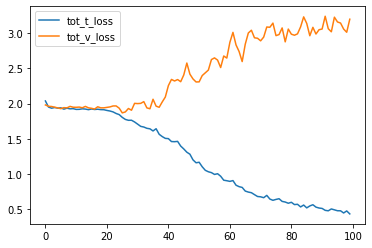

In [314]:
plt.plot(tot_t_loss, label='tot_t_loss')
plt.plot(tot_v_loss, label = 'tot_v_loss')
plt.legend()